In [1]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from tf_lab.fundamentals.utils import set_visible_GPUs, reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec


from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id, match_incomplete_to_complete_data
from tf_lab.autopredictors.scripts import loading_virt_scan_data as vscan

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch, \
                                           plot_interpolations
from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs
                                                  


from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
n_points = 2048

experiment_name = '1_virt_scan_chamfer_2fc_decoder_' + str(n_points) + 'pts_all_views'

do_training = True
do_plotting = True
first_time_running = True
load_model = False

class_type = raw_input('Give me the class type.\n').lower()
class_syn_id = shape_net_category_to_synth_id()[class_type]

Give me the class type.
chair


In [9]:
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
full_pclouds_path = osp.join(top_data_dir, 'ShapeNetPointClouds/from_manifold_meshes/' + str(n_points), class_syn_id)

train_dir = osp.join(top_data_dir, 'OUT/models/incomplete_pclouds/')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

'/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/1_virt_scan_chamfer_2fc_decoder_2048pts_all_views'

In [10]:
train_id_file = '/orions4-zfs/projects/lins2/Panos_Space/DATA/From_Matthias/shapenet_all-train.txt'
v_scan_top_dir = osp.join(top_data_dir, 'From_Matthias/shapenet_dim32_sdf_pc', class_syn_id)
search_pattern = '.ply'

full_file_names = pio.load_filenames_of_input_data(full_pclouds_path)
full_pclouds, full_model_names, class_ids = pio.load_crude_point_clouds(file_names=full_file_names, n_threads=20)

print '%d files containing complete point clouds were found.' % (len(full_pclouds), )


train_data = vscan.load_single_class_incomplete_dataset(v_scan_top_dir, train_id_file, class_syn_id, 
                                                      full_pclouds, full_model_names, n_threads=24,
                                                      n_samples=n_points , search_pattern=search_pattern)

6778 files containing complete point clouds were found.
40000 incomplete point clouds were loaded.


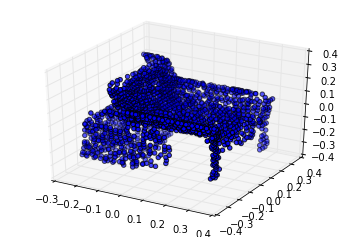

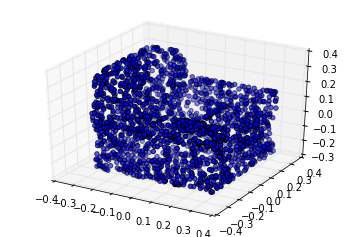

In [15]:
# TRY ME.
pp = train_data.next_batch(1)
Point_Cloud(points=pp[2].reshape(2048, 3)).plot();
Point_Cloud(points=pp[0].reshape(2048, 3)).plot();

In [16]:
if load_model:
    conf = Conf.load(osp.join(train_dir, 'configuration'))
    print conf
else:
    n_input = [n_points, 3]    
    decoder_args = {'layer_sizes': [1024, np.prod(n_input)], 
                    'non_linearity': tf.nn.relu
                   }

    conf = Conf(
                n_input = n_input,
                denoising = True,
                training_epochs = 200,
                batch_size = 50,
                loss = 'chamfer',
                train_dir = train_dir,
                loss_display_step = 1,
                saver_step = 10,
                learning_rate = 0.00002,
                saver_max_to_keep = 50,
                gauss_augment = {'mu': 0, 'sigma': 0.01},
                encoder = enc_dec.encoder_with_convs_and_symmetry,
                decoder = enc_dec.decoder_with_fc_only,
                decoder_args = decoder_args,
               )

    conf.experiment_name = experiment_name
    conf.save(osp.join(conf.train_dir, 'configuration'))

In [17]:
reset_tf_graph()
set_visible_GPUs([3])
ae = PointNetAutoEncoder(experiment_name, conf)

if do_training:
    ae.train(train_data, conf)

else:
    saved_epochs = read_saved_epochs(conf.train_dir)
    ae.restore_model(train_dir, saved_epochs[-1])

('Epoch:', '0001', 'training time (minutes)=', '1.4015', 'loss=', '0.003188887')
('Epoch:', '0002', 'training time (minutes)=', '1.4391', 'loss=', '0.002459431')
('Epoch:', '0003', 'training time (minutes)=', '1.4330', 'loss=', '0.002232427')
('Epoch:', '0004', 'training time (minutes)=', '1.5833', 'loss=', '0.002087334')
('Epoch:', '0005', 'training time (minutes)=', '1.4330', 'loss=', '0.001987582')
('Epoch:', '0006', 'training time (minutes)=', '1.4536', 'loss=', '0.001919554')
('Epoch:', '0007', 'training time (minutes)=', '1.3835', 'loss=', '0.001866537')
('Epoch:', '0008', 'training time (minutes)=', '1.4268', 'loss=', '0.001825837')
('Epoch:', '0009', 'training time (minutes)=', '1.4354', 'loss=', '0.001788544')
('Epoch:', '0010', 'training time (minutes)=', '1.4201', 'loss=', '0.001760752')
('Epoch:', '0011', 'training time (minutes)=', '1.3934', 'loss=', '0.001734258')
('Epoch:', '0012', 'training time (minutes)=', '1.4064', 'loss=', '0.001710545')
('Epoch:', '0013', 'training

In [18]:
test_id_file = '/orions4-zfs/projects/lins2/Panos_Space/DATA/From_Matthias/shapenet_all-test.txt'
test_data = vscan.load_single_class_incomplete_dataset(v_scan_top_dir, test_id_file, class_syn_id, 
                                                      full_pclouds, full_model_names, n_threads=24,
                                                      n_samples=n_points, search_pattern=search_pattern)

8000 incomplete point clouds were loaded.


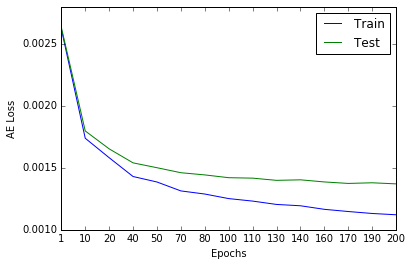

In [19]:
if do_plotting:
    saved_epochs = read_saved_epochs(conf.train_dir)
    plot_epochs = select_first_last_and_k(saved_epochs, 13)
    stats = eval_model(ae, conf, [train_data, test_data], epochs=plot_epochs)
    top_save_dir = osp.join(conf.train_dir, 'model_evaluation')
    plot_train_val_test_curves(stats, top_save_dir, has_validation=False, best_epoch=None, show=True)
    last_epoch = saved_epochs[-1]
    save_dir = osp.join(top_save_dir, 'train_images_epoch_' + str(last_epoch))
    plot_reconstructions_at_epoch(last_epoch, ae, train_data, conf, save_dir=save_dir, max_plot=300)    
    save_dir = osp.join(top_save_dir, 'test_images_epoch_' + str(last_epoch))
    plot_reconstructions_at_epoch(last_epoch, ae, test_data, conf, save_dir=save_dir, max_plot=300)